In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
%matplotlib inline
pd.set_option('display.max_columns', None)

/kaggle/input/wine-quality-dataset/winequality-white.csv
/kaggle/input/wine-quality-dataset/winequality-red.csv


In [2]:
df = pd.read_csv('../input/wine-quality-dataset/winequality-white.csv', sep=";")
df.shape

(4898, 12)

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


**Checking for Missing Values**

In [5]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

**Quality Count**

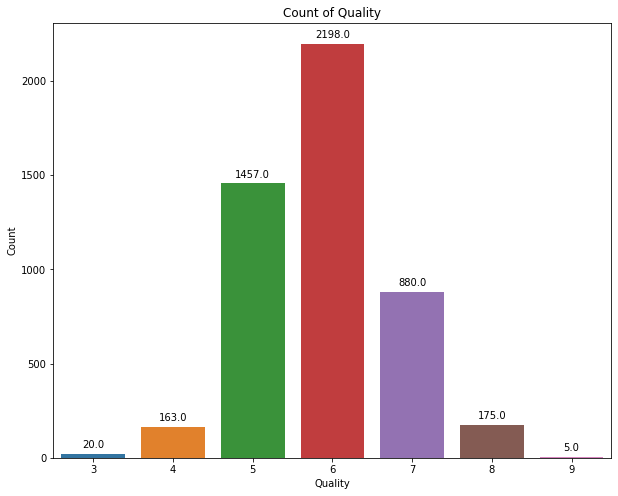

In [6]:
fig, ax = plt.subplots(figsize=(10, 8)) 
sns.countplot(ax=ax, x = 'quality', data=df)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Count of Quality')

plt.show()

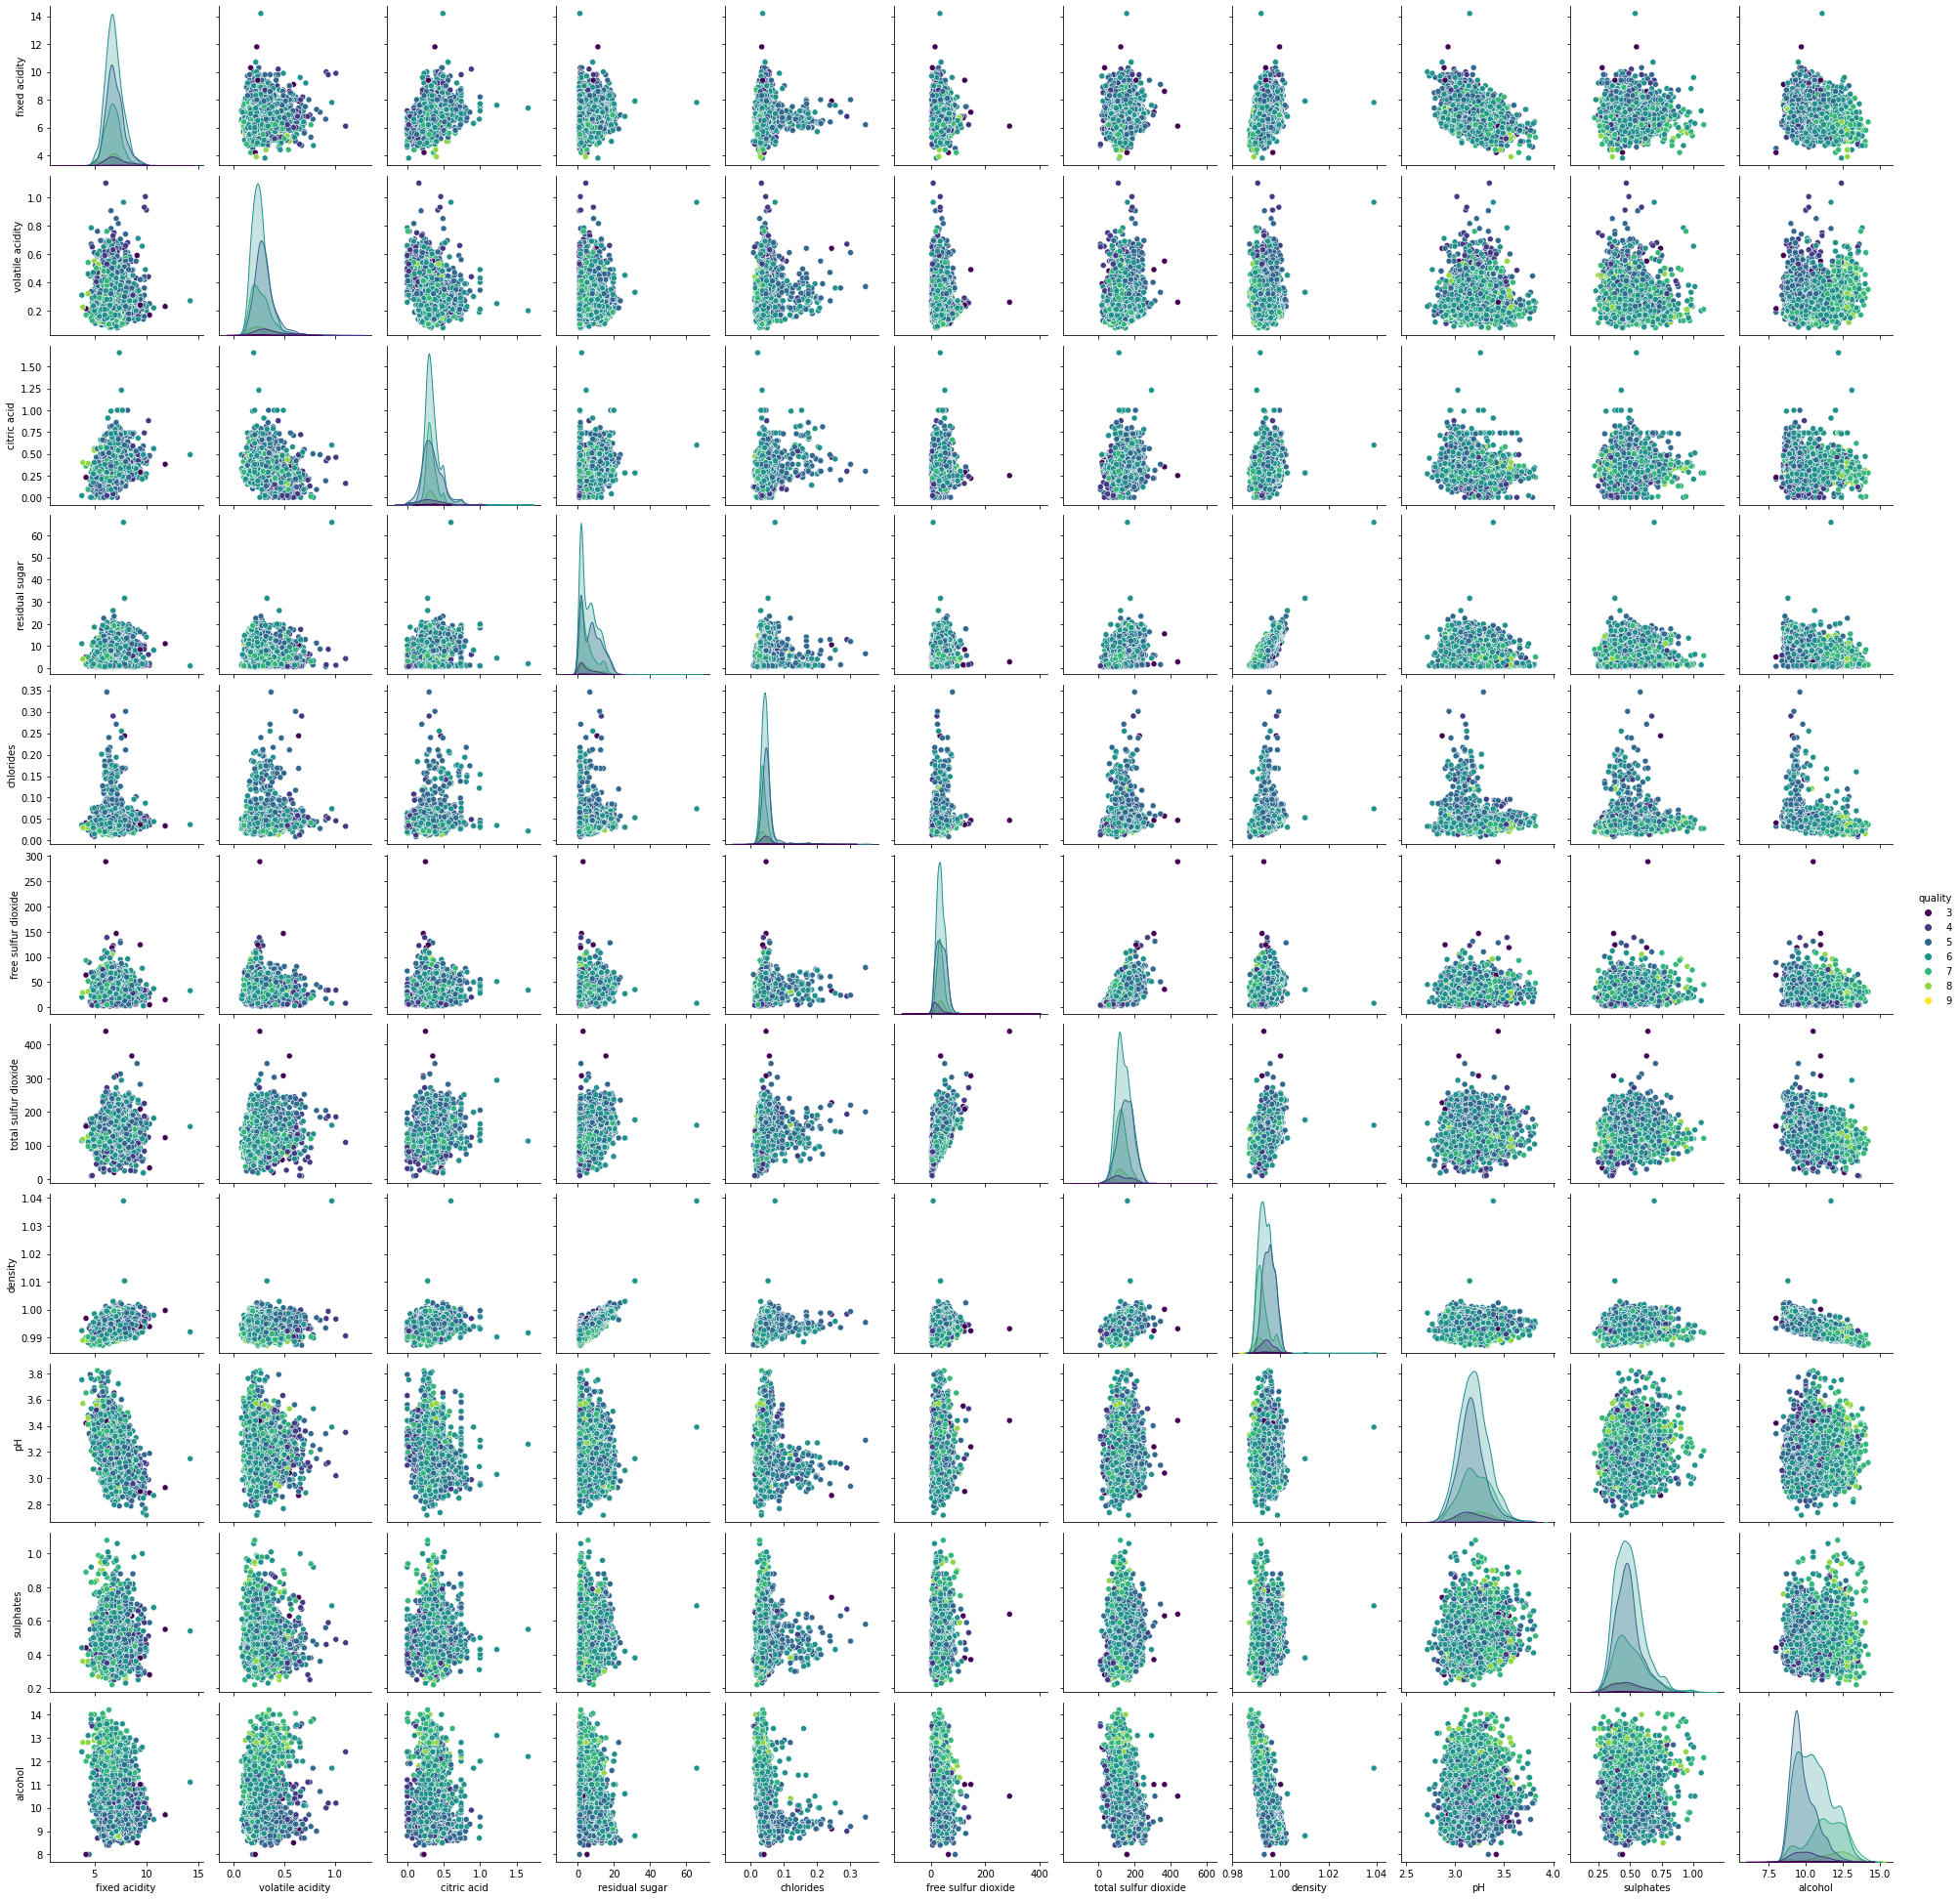

In [7]:
sns.pairplot(df, hue='quality', palette='viridis')

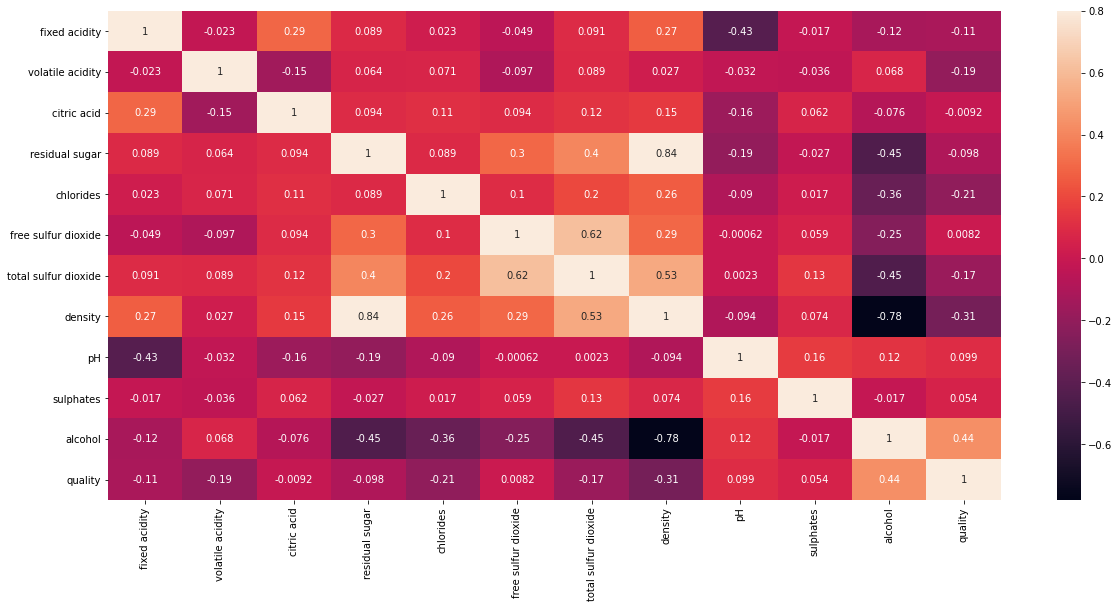

In [8]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(20,9))
sns.heatmap(corrmat, vmax=0.8, annot=True)
plt.show()

Text(0.5, 1.0, 'Relationship between Quality and Density')

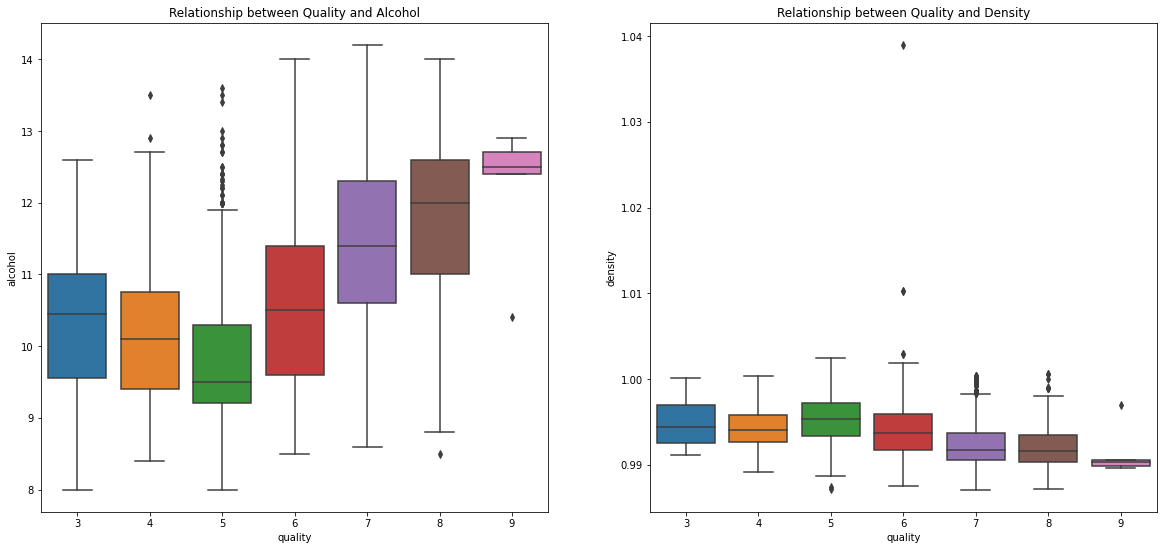

In [9]:
f, ax = plt.subplots(1, 2, figsize=(20,9))
sns.boxplot(data=df, x='quality', y='alcohol', ax=ax[0])
ax[0].set_title('Relationship between Quality and Alcohol')
sns.boxplot(data=df, x='quality', y='density', ax=ax[1])
ax[1].set_title('Relationship between Quality and Density')

**Features and Target Variable**

In [10]:
df_feat = df.iloc[:,:-1]
cols = df_feat.columns
df_target = df['quality']

**Scaling Features**

In [11]:
scaler = StandardScaler()
df_feat = scaler.fit_transform(df_feat)
df_feat = pd.DataFrame(df_feat, columns=cols)
df_feat.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152
1,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276
2,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667
3,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203
4,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203


**Splitting Training and Test Set**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size=0.3, random_state=0, stratify=df_target)
X_train.shape, X_test.shape

((3428, 11), (1470, 11))

In [13]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
3071,-0.420473,0.811227,0.378559,0.750972,-0.813539,-0.900190,-1.326329,-0.430474,-0.584605,-0.524447,1.288695
410,0.409125,-0.280214,0.461199,2.476286,-0.355784,0.393517,0.391572,1.963693,-1.445616,-0.173921,-1.230616
944,-0.420473,-0.974766,-0.034638,0.317179,0.239298,-1.135409,-0.173218,0.826798,0.607565,-0.436816,-1.474421
537,0.646153,-0.280214,0.213280,1.342508,0.971706,1.040370,0.932828,1.194617,-1.180690,-0.086290,-1.230616
1700,-0.183445,-0.180992,-0.282557,-0.905330,-0.126906,-0.606165,-0.408546,0.124598,1.667272,1.052920,-0.255399


***Baseline***

In [14]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
print('Test Accuracy Score: {0:0.4f}'.format(metrics.accuracy_score(y_test, dummy_pred)))

Test Accuracy Score: 0.4490


In [15]:
score = cross_val_score(dummy, df_feat, df_target, cv=5, scoring='accuracy').mean()
print('Cross Validation Score: {0:0.4f}'.format(score))

Cross Validation Score: 0.4488


***Logistic Regression***

In [16]:
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Test Accuracy Score: {0:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))

Test Accuracy Score: 0.5476


<AxesSubplot:>

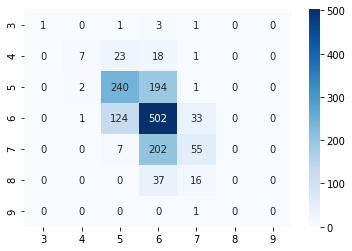

In [17]:
c_mat = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(c_mat, annot=True, fmt='g', cmap='Blues', xticklabels=[3,4,5,6,7,8,9], yticklabels=[3,4,5,6,7,8,9])

In [18]:
print(metrics.classification_report(y_test,y_pred, zero_division=0))

              precision    recall  f1-score   support

           3       1.00      0.17      0.29         6
           4       0.70      0.14      0.24        49
           5       0.61      0.55      0.58       437
           6       0.53      0.76      0.62       660
           7       0.51      0.21      0.30       264
           8       0.00      0.00      0.00        53
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1470
   macro avg       0.48      0.26      0.29      1470
weighted avg       0.54      0.55      0.51      1470



In [19]:
class_names = list(y_test.unique())
class_names.sort()
for class_name in class_names:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1],
                                             pos_label=class_name)
    auroc = round(metrics.auc(fpr, tpr),2)
    print('Class ', class_name, ' AUC: ', auroc)

Class  3  AUC:  0.34
Class  4  AUC:  0.8
Class  5  AUC:  0.68
Class  6  AUC:  0.44
Class  7  AUC:  0.34
Class  8  AUC:  0.3
Class  9  AUC:  0.43


In [20]:
score = cross_val_score(model, df_feat, df_target, cv=5, scoring='accuracy').mean()
print('Cross Validation Score: {0:0.4f}'.format(score))

Cross Validation Score: 0.5247


***Decision Tree***

**Default Tree**

In [21]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
print('Test Accuracy Score (Default Tree): {0:0.4f}'.format(metrics.accuracy_score(y_test,tree_pred)))

Test Accuracy Score (Default Tree): 0.5878


In [22]:
score = cross_val_score(tree, df_feat, df_target, cv=5, scoring='accuracy').mean()
print('Cross Validation Score (Default Tree): {0:0.4f}'.format(score))

Cross Validation Score (Default Tree): 0.4061


**Tuned Tree**

In [23]:
depth_range = range(1,11)
accuracy = list()

for depth in depth_range:
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    score = cross_val_score(tree, df_feat, df_target, cv=5, scoring='accuracy').mean()
    accuracy.append((depth,round(score,4)))

best_depth = max(accuracy, key=itemgetter(1))
print('The tree depth with the best Cross Validation Score is', best_depth[0])

The tree depth with the best Cross Validation Score is 3


In [24]:
tuned_tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tuned_tree.fit(X_train, y_train)
tuned_tree_pred = tuned_tree.predict(X_test)
print('Test Accuracy Score (Tuned Tree): {0:0.4f}'.format(metrics.accuracy_score(y_test,tuned_tree_pred)))

Test Accuracy Score (Tuned Tree): 0.5102


<AxesSubplot:>

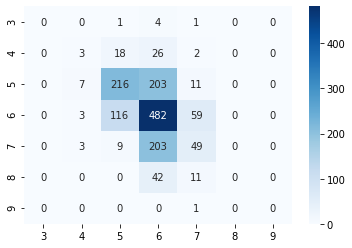

In [25]:
c_mat_tree = metrics.confusion_matrix(y_test, tuned_tree_pred)
sns.heatmap(c_mat_tree, annot=True, fmt='g', cmap='Blues', xticklabels=[3,4,5,6,7,8,9], yticklabels=[3,4,5,6,7,8,9])

In [26]:
print(metrics.classification_report(y_test, tuned_tree_pred, zero_division=0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.19      0.06      0.09        49
           5       0.60      0.49      0.54       437
           6       0.50      0.73      0.60       660
           7       0.37      0.19      0.25       264
           8       0.00      0.00      0.00        53
           9       0.00      0.00      0.00         1

    accuracy                           0.51      1470
   macro avg       0.24      0.21      0.21      1470
weighted avg       0.48      0.51      0.48      1470



In [27]:
for class_name in class_names:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, tuned_tree.predict_proba(X_test)[:,1],
                                             pos_label=class_name)
    auroc = round(metrics.auc(fpr, tpr),2)
    print('Class ', class_name, ' AUC: ', auroc)

Class  3  AUC:  0.31
Class  4  AUC:  0.73
Class  5  AUC:  0.71
Class  6  AUC:  0.47
Class  7  AUC:  0.27
Class  8  AUC:  0.25
Class  9  AUC:  0.05


In [28]:
score = cross_val_score(tuned_tree, df_feat, df_target, cv=5, scoring='accuracy').mean()
print('Cross Validation Score (Tuned Tree): {0:0.4f}'.format(score))

Cross Validation Score (Tuned Tree): 0.5153


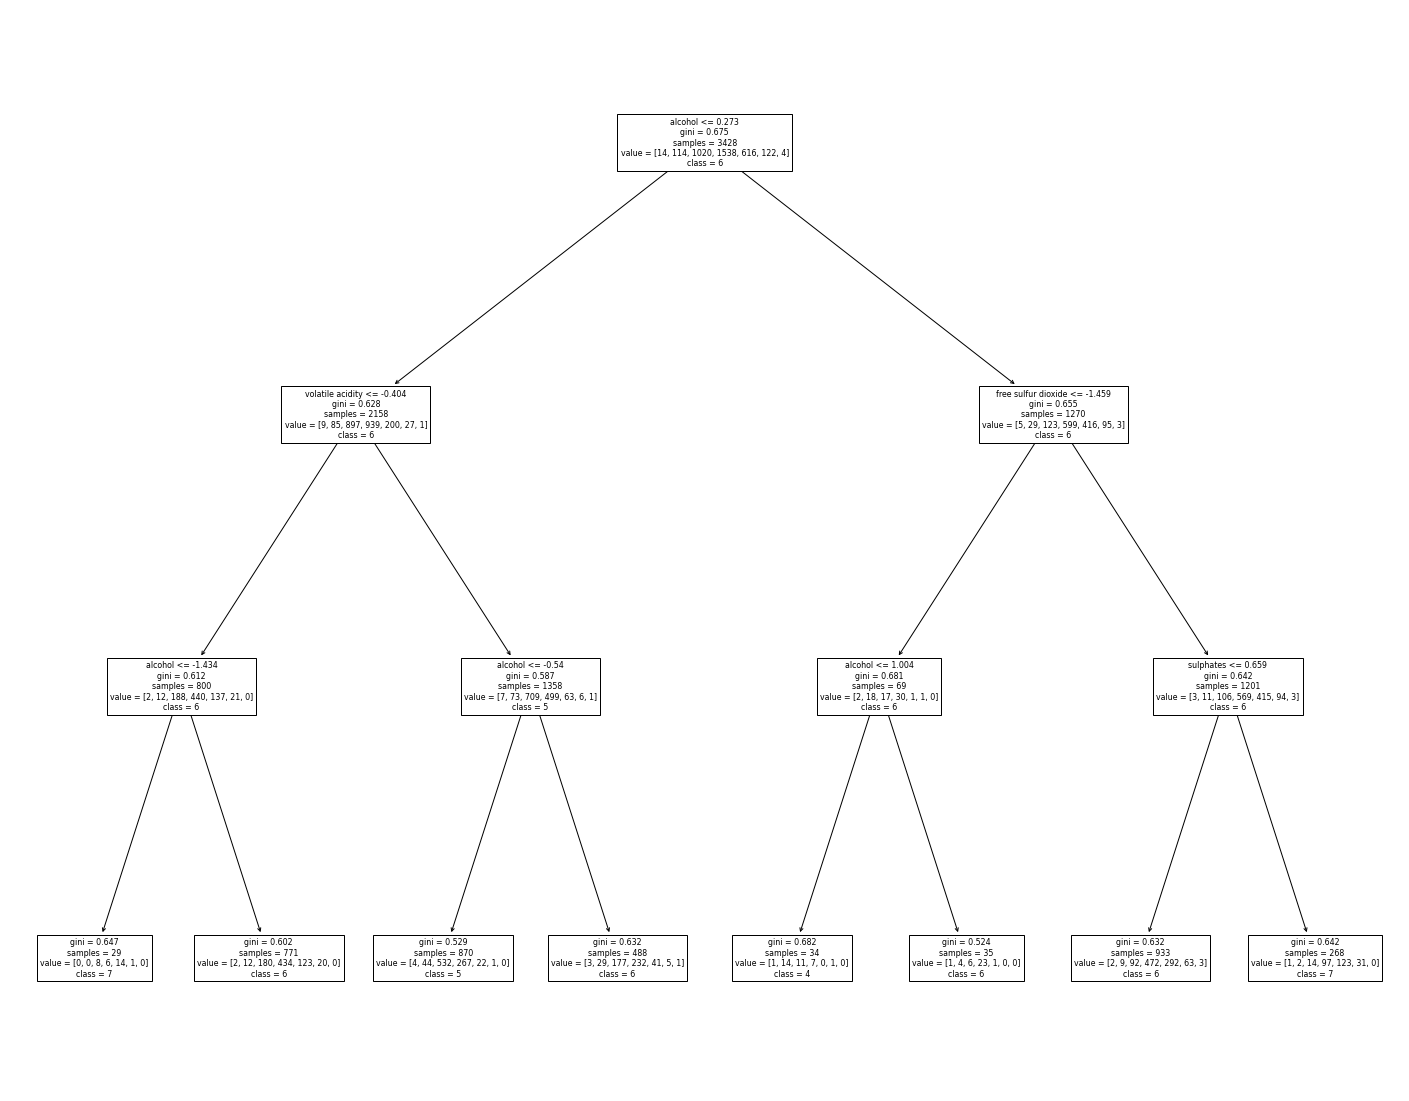

In [29]:
fig = plt.figure(figsize=(25,20))
plot_tree(tuned_tree, feature_names=df_feat.columns, class_names=['3','4','5','6','7','8','9'])
plt.show()

***XGBoost***

In [30]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
y_pred_xgb = xgb.predict(X_test)
print('Test Accuracy Score: {0:0.4f}'.format(metrics.accuracy_score(y_test,y_pred_xgb)))

Test Accuracy Score: 0.6551


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


<AxesSubplot:>

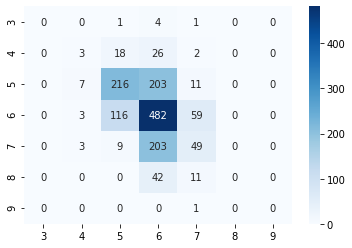

In [32]:
c_mat_xgb = metrics.confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(c_mat_tree, annot=True, fmt='g', cmap='Blues', xticklabels=[3,4,5,6,7,8,9], yticklabels=[3,4,5,6,7,8,9])

In [33]:
print(metrics.classification_report(y_test, y_pred_xgb, zero_division=0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.45      0.18      0.26        49
           5       0.68      0.67      0.68       437
           6       0.65      0.76      0.70       660
           7       0.63      0.50      0.56       264
           8       0.81      0.47      0.60        53
           9       0.00      0.00      0.00         1

    accuracy                           0.66      1470
   macro avg       0.46      0.37      0.40      1470
weighted avg       0.65      0.66      0.65      1470



In [34]:
for class_name in class_names:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb.predict_proba(X_test)[:,1],
                                             pos_label=class_name)
    auroc = round(metrics.auc(fpr, tpr),2)
    print('Class ', class_name, ' AUC: ', auroc)

Class  3  AUC:  0.79
Class  4  AUC:  0.83
Class  5  AUC:  0.68
Class  6  AUC:  0.46
Class  7  AUC:  0.3
Class  8  AUC:  0.21
Class  9  AUC:  0.14


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will gen

In [35]:
score = cross_val_score(xgb, df_feat, df_target, cv=5, scoring='accuracy').mean()
print('Cross Validation Score: {0:0.4f}'.format(score))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross Validation Score: 0.5098


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Text(0.5, 1.0, 'Features Importance')

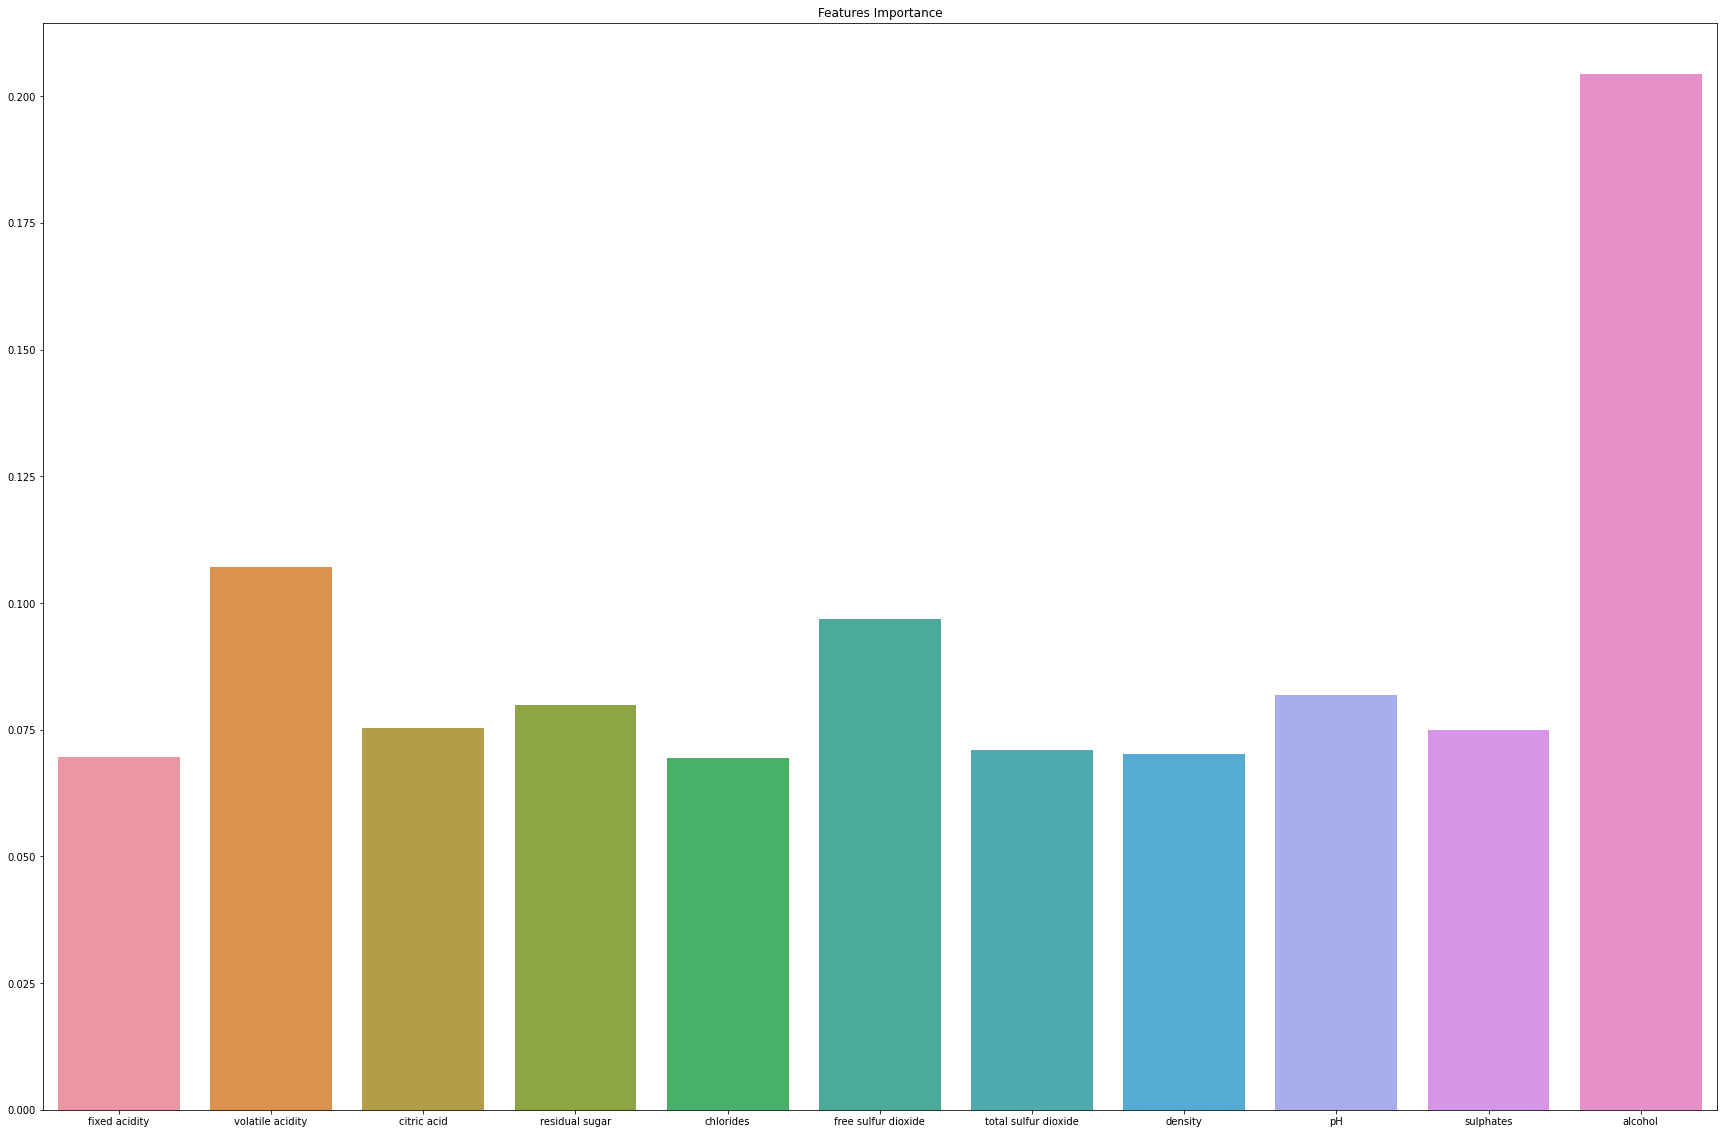

In [36]:
fig = plt.figure(figsize=(30,20))
sns.barplot(x=df_feat.columns, y=xgb.feature_importances_)
plt.title('Features Importance')

***Keras***

In [37]:
df_target_encoded = pd.get_dummies(df_target).values
df_feat_val = df_feat.values

In [38]:
train_X, test_X, train_y, test_y = train_test_split(df_feat_val, df_target_encoded, test_size=0.3, random_state=0, stratify=df_target_encoded)

In [39]:
keras_model = Sequential([
    Dense(6, input_shape=(11,), activation='relu'),
    Dense(6, activation='relu'),
    Dense(7, activation='softmax')
    ])
    
keras_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
keras_model.fit(train_X, train_y, epochs=100, batch_size=32, verbose=0)

In [41]:
keras_pred = keras_model.predict(test_X)
keras_result = []
for i in range(len(keras_pred)):
    keras_result.append(np.argmax(keras_pred[i]))
keras_model.evaluate(test_X, test_y)

46/46 [==============================] - 0s 965us/step - loss: 1.0922 - accuracy: 0.5531


[1.092227816581726, 0.5530612468719482]

In [42]:
test_Y = list()
for i in range(len(test_y)):
    test_Y.append(np.argmax(test_y[i]))

In [43]:
print('Test Accuracy Score: {0:0.4f}'.format(metrics.accuracy_score(test_Y,keras_result)))

Test Accuracy Score: 0.5531


<AxesSubplot:>

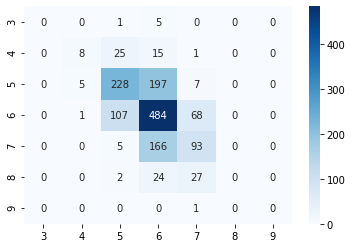

In [44]:
c_mat_keras = metrics.confusion_matrix(test_Y, keras_result)
sns.heatmap(c_mat_keras, annot=True, fmt='g', cmap='Blues', xticklabels=[3,4,5,6,7,8,9], yticklabels=[3,4,5,6,7,8,9])

In [45]:
print(metrics.classification_report(test_Y, keras_result, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.57      0.16      0.25        49
           2       0.62      0.52      0.57       437
           3       0.54      0.73      0.62       660
           4       0.47      0.35      0.40       264
           5       0.00      0.00      0.00        53
           6       0.00      0.00      0.00         1

    accuracy                           0.55      1470
   macro avg       0.32      0.25      0.26      1470
weighted avg       0.53      0.55      0.53      1470



In [46]:
for i in [0,1,2,3,4,5,6]:
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, keras_model.predict_proba(test_X)[:,1],
                                             pos_label=i)
    auroc = round(metrics.auc(fpr, tpr),2)
    print('Class ', i+3, ' AUC: ', auroc)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Class  3  AUC:  0.51
Class  4  AUC:  0.83
Class  5  AUC:  0.75


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Class  6  AUC:  0.44
Class  7  AUC:  0.25
Class  8  AUC:  0.22
Class  9  AUC:  0.09


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [47]:
def baseline_model():
    keras_model = Sequential([
    Dense(6, input_shape=(11,), activation='relu'),
    Dense(6, activation='relu'),
    Dense(7, activation='softmax')
    ])
    
    keras_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return keras_model

In [48]:
keras_estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=100, batch_size=32)

In [49]:
results = cross_val_score(keras_estimator, df_feat, df_target, cv=5, scoring='accuracy')
print('Cross Validation Score: {0:0.4f}'.format(results.mean()))

123/123 [==============================] - 0s 1ms/step - loss: 2.0292 - accuracy: 0.1551


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


123/123 [==============================] - 0s 1ms/step - loss: 1.8928 - accuracy: 0.4339


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


123/123 [==============================] - 1s 1ms/step - loss: 2.0362 - accuracy: 0.1247


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


123/123 [==============================] - 0s 1ms/step - loss: 1.9516 - accuracy: 0.2292


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


123/123 [==============================] - 1s 1ms/step - loss: 1.9555 - accuracy: 0.1342


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Cross Validation Score: 0.3460


***PyTorch***

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [51]:
train_X = torch.FloatTensor(train_X)
test_X = torch.FloatTensor(test_X)
train_y = torch.LongTensor(train_y)
test_y = torch.LongTensor(test_y)

In [52]:
df.shape

(4898, 12)

In [53]:
class MLP(nn.Module):
    def __init__(self, input_features=11, hidden1=20, hidden2=20, output_features=7):
        super().__init__()
        self.f_connected1 = nn.Linear(input_features, hidden1)
        self.f_connected2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, output_features)
        
    def forward(self,x):
        x = F.relu(self.f_connected1(x))
        x = F.relu(self.f_connected2(x))
        x = self.out(x)
        return x

In [54]:
torch.manual_seed(20)
model = MLP()
model.parameters()

<generator object Module.parameters at 0x7fbb97c030d0>

In [55]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [56]:
final_losses = list()
for epoch in range(500):
    i = i+1
    torch_pred = model.forward(train_X)
    loss = loss_function(torch_pred, torch.max(train_y,1)[1])
    final_losses.append(loss)
    if i%10 == 1:
        print("Epoch number {} has loss: {}".format(i, loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number 11 has loss: 1.3788821697235107
Epoch number 21 has loss: 1.1508560180664062
Epoch number 31 has loss: 1.059369444847107
Epoch number 41 has loss: 1.0155773162841797
Epoch number 51 has loss: 0.9876896142959595
Epoch number 61 has loss: 0.9671143889427185
Epoch number 71 has loss: 0.9510701894760132
Epoch number 81 has loss: 0.9367059469223022
Epoch number 91 has loss: 0.9249913692474365
Epoch number 101 has loss: 0.9210554957389832
Epoch number 111 has loss: 0.9085878729820251
Epoch number 121 has loss: 0.9021742343902588
Epoch number 131 has loss: 0.8980227112770081
Epoch number 141 has loss: 0.893204927444458
Epoch number 151 has loss: 0.8891860842704773
Epoch number 161 has loss: 0.8806730508804321
Epoch number 171 has loss: 0.8741024732589722
Epoch number 181 has loss: 0.8680455088615417
Epoch number 191 has loss: 0.8884967565536499
Epoch number 201 has loss: 0.8667651414871216
Epoch number 211 has loss: 0.8624078631401062
Epoch number 221 has loss: 0.8565036654472351

Text(0, 0.5, 'Loss')

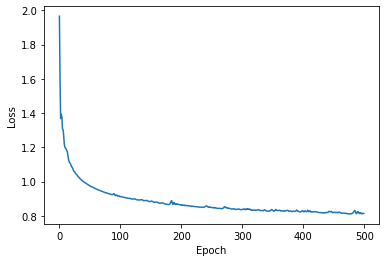

In [57]:
plt.plot(range(500), final_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [58]:
test_Y = list()
for i in range(len(test_y)):
    test_Y.append(np.argmax(test_y[i]))

In [59]:
prediction = list()
with torch.no_grad():
    for i, data in enumerate(test_X):
        torch_pred = model(data)
        prediction.append(torch_pred.argmax().item())
print('Test Accuracy Score: {0:0.4f}'.format(metrics.accuracy_score(test_Y, prediction)))

Test Accuracy Score: 0.5395


<AxesSubplot:>

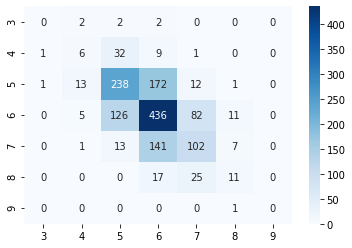

In [60]:
c_mat_torch = metrics.confusion_matrix(test_Y, prediction)
sns.heatmap(c_mat_torch, annot=True, fmt='g', cmap='Blues', xticklabels=[3,4,5,6,7,8,9], yticklabels=[3,4,5,6,7,8,9])

In [61]:
print(metrics.classification_report(test_Y, prediction, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.22      0.12      0.16        49
           2       0.58      0.54      0.56       437
           3       0.56      0.66      0.61       660
           4       0.46      0.39      0.42       264
           5       0.35      0.21      0.26        53
           6       0.00      0.00      0.00         1

    accuracy                           0.54      1470
   macro avg       0.31      0.27      0.29      1470
weighted avg       0.53      0.54      0.53      1470

